# **1. Dataset Split**

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Read the data
url = 'https://raw.githubusercontent.com/YuanColab/Dengue-NS3-active-small-molecules-classifier/main/Data/NS3_feature_SVM_RFE.csv'
df = pd.read_csv(url)

# Separate features and labels
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Split the dataset ensuring class balance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Output the shape of the datasets
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((472, 681), (119, 681), (472,), (119,))

# **2. Define Evaluation Function**

In [ ]:
# Function Definitions
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer

def evaluate_cross_validation(estimator, X, y, cv=10):
    scoring = {
        'Accuracy': 'accuracy',
        'Precision': 'precision',
        'Recall': 'recall',
        'F1_score': 'f1',
        'MCC': make_scorer(matthews_corrcoef),
        'ROC_AUC': 'roc_auc'
    }

    cv_results = cross_validate(estimator, X, y, cv=cv, scoring=scoring)
    cv_metrics = {}
    for metric in scoring.keys():
        mean_score = np.mean(cv_results[f'test_{metric}'])
        cv_metrics[metric] = f"{mean_score:.3f}"

    return cv_metrics

def evaluate_model(y_true, y_pred, y_pred_proba):
    conf_matrix = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred_proba)

    metrics_dict = {
        "Confusion Matrix": conf_matrix,
        "Accuracy": f"{accuracy:.3f}",
        "Precision": f"{precision:.3f}",
        "Recall": f"{recall:.3f}",
        "F1_Score": f"{f1:.3f}",
        "MCC": f"{mcc:.3f}",
        "ROC_AUC": f"{roc_auc:.3f}"
    }

    return metrics_dict

def plot_confusion_matrix(conf_matrix, title='Confusion Matrix', filename='confusion_matrix.png'):
    cm_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    labels = (np.asarray(["{0:0.0f}\n{1:.2%}".format(value, percentage)
                      for value, percentage in zip(conf_matrix.flatten(), cm_normalized.flatten())])
          .reshape(2, 2))
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=labels, fmt='', cmap='Blues')
    plt.title(title)
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.savefig(filename)
    plt.show()

def plot_roc_curve(y_true, y_pred_proba, title='Receiver Operating Characteristic', filename='roc_curve.png'):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.savefig(filename)
    plt.show()

# **3. Machine Learning Models**

## **3.1 SVM**

In [ ]:
pip install seaborn

   ---------------------------------------- 0.0/294.6 kB ? eta -:--:--
   - -------------------------------------- 10.2/294.6 kB ? eta -:--:--
   ------------ --------------------------- 92.2/294.6 kB 1.7 MB/s eta 0:00:01
   --------------------------- ------------ 204.8/294.6 kB 1.8 MB/s eta 0:00:01
   ---------------------------------------- 294.6/294.6 kB 1.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


Optimal parameters: {'C': 0.1, 'gamma': 0.001, 'kernel': 'linear'}

Training Set - 10-Fold Cross Validation Metrics:
{'Accuracy': '0.854', 'Precision': '0.848', 'Recall': '0.862', 'F1_score': '0.851', 'MCC': '0.714', 'ROC_AUC': '0.936'}


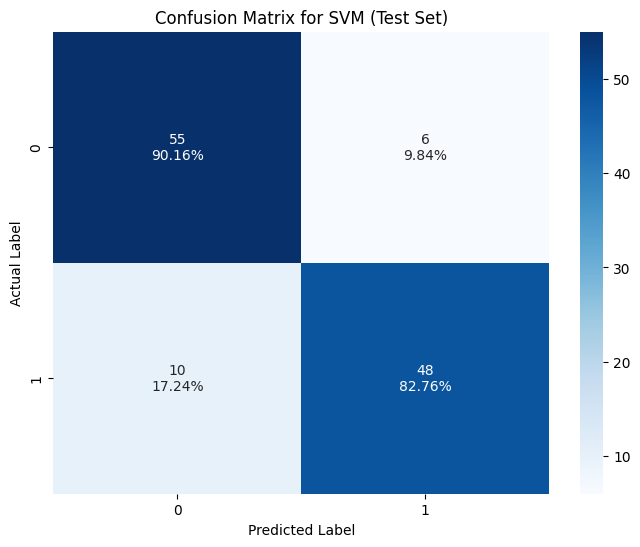

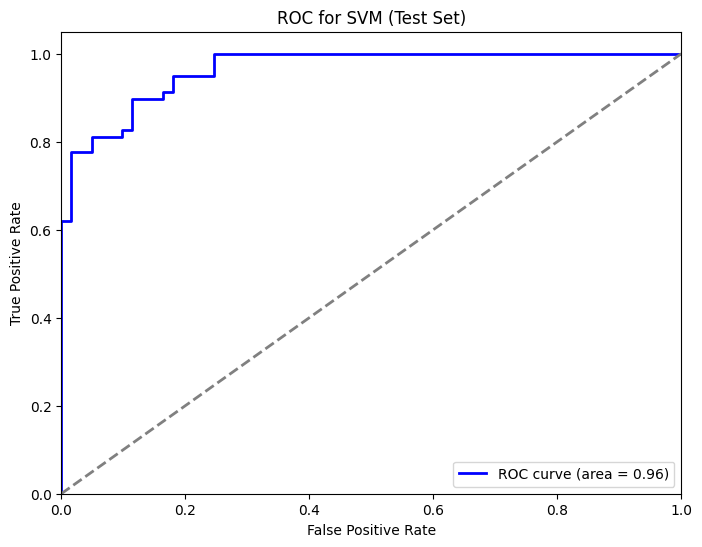

Test Set Metrics:
  Accuracy Precision Recall F1_Score    MCC ROC_AUC
0    0.866     0.889  0.828    0.857  0.732   0.964


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score, roc_curve, auc

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Define parameter values directly
C_list = [0.001, 0.01, 0.1, 1, 10, 100]
gamma_list = [0.001, 0.01, 0.1, 1]
kernel_list = ['rbf', 'linear']

# Set up parameter grid for grid search
param_grid_svm = {
    'C': C_list,
    'gamma': gamma_list,
    'kernel': kernel_list
}

# Instantiate SVM classifier and conduct grid search
svm = SVC(probability=True)
grid_search = GridSearchCV(svm, param_grid_svm, scoring='accuracy', cv=cv)
grid_search.fit(X_train, y_train)

# Output the optimal parameters
best_params_svm = grid_search.best_params_
best_model_svm = grid_search.best_estimator_
print("Optimal parameters:", best_params_svm)

# Predict and Evaluate on Training Set
cv_metrics_svm_train = evaluate_cross_validation(best_model_svm, X_train, y_train)
print("\nTraining Set - 10-Fold Cross Validation Metrics:")
print(cv_metrics_svm_train)

# Predict and Evaluate on Test Set
y_pred_test = best_model_svm.predict(X_test)
y_pred_proba_test = best_model_svm.predict_proba(X_test)[:, 1]
metrics_dict_svm_test = evaluate_model(y_test, y_pred_test, y_pred_proba_test)

# Visualization and Saving Plots
plot_confusion_matrix(metrics_dict_svm_test['Confusion Matrix'], title='Confusion Matrix for SVM (Test Set)', filename='confusion_matrix_SVM_test.png')
plot_roc_curve(y_test, y_pred_proba_test, title='ROC for SVM (Test Set)', filename='roc_curve_SVM_test.png')

# Convert Evaluation Metrics to DataFrame
metrics_df_svm_test = pd.DataFrame({k: [v] for k, v in metrics_dict_svm_test.items() if k != 'Confusion Matrix'})

# Display Metrics DataFrames
print("Test Set Metrics:")
print(metrics_df_svm_test)


## **3.2 RandomForest(RF)**

Optimal parameters: {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}

Training Set - 10-Fold Cross Validation Metrics:
{'Accuracy': '0.801', 'Precision': '0.847', 'Recall': '0.729', 'F1_score': '0.780', 'MCC': '0.610', 'ROC_AUC': '0.896'}


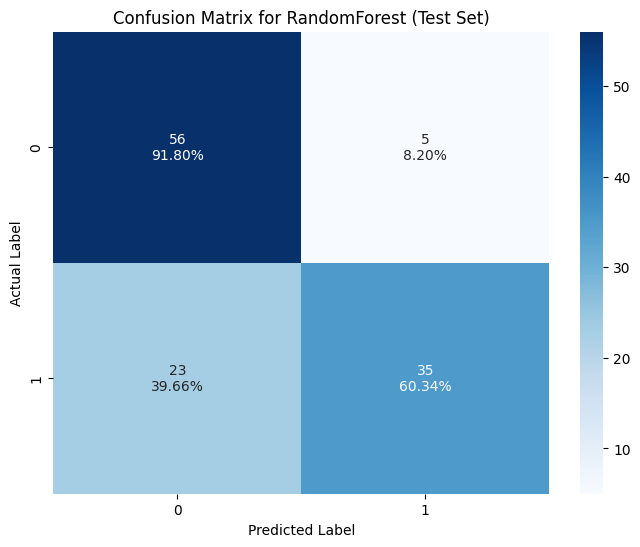

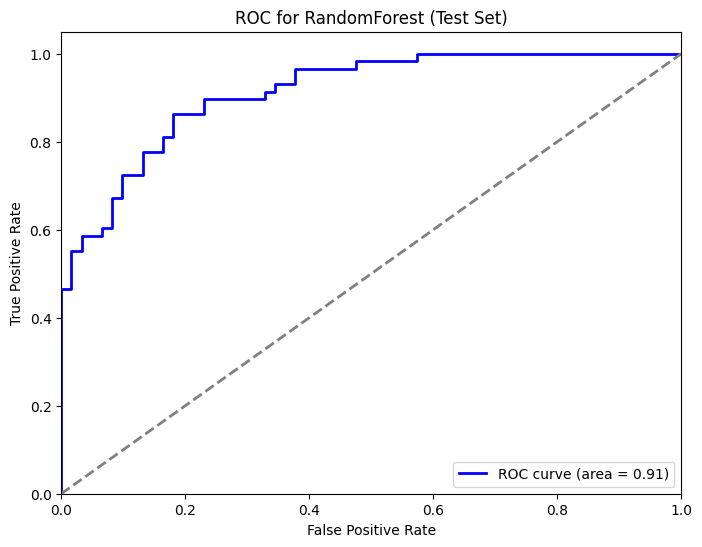


Test Set Metrics:
  Accuracy Precision Recall F1_Score    MCC ROC_AUC
0    0.765     0.875  0.603    0.714  0.552   0.913


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score, roc_curve

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Define parameter values directly
n_estimators_list = [100, 200, 300, 400, 500]
max_depth_list = [5, 10, 15]
min_samples_split_list = [2, 4, 6]
min_samples_leaf_list = [1, 2, 3]

# Set up parameter grid for grid search
param_grid_rf = {
    'n_estimators': n_estimators_list,
    'max_depth': max_depth_list,
    'min_samples_split': min_samples_split_list,
    'min_samples_leaf': min_samples_leaf_list
}

# Instantiate RandomForest classifier and conduct grid search
rf = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(rf, param_grid_rf, scoring='accuracy', cv=cv)
grid_search_rf.fit(X_train, y_train)

# Retrieve and display the optimal parameters
best_params_rf = grid_search_rf.best_params_
best_model_rf = grid_search_rf.best_estimator_
print("Optimal parameters:", best_params_rf)

# Predict and Evaluate on Training Set
cv_metrics_rf_train = evaluate_cross_validation(best_model_rf, X_train, y_train)
print("\nTraining Set - 10-Fold Cross Validation Metrics:")
print(cv_metrics_rf_train)

# Predict and Evaluate on Test Set
y_pred_test_rf = best_model_rf.predict(X_test)
y_pred_proba_test_rf = best_model_rf.predict_proba(X_test)[:, 1]
metrics_dict_rf_test = evaluate_model(y_test, y_pred_test_rf, y_pred_proba_test_rf)

# Visualization and Saving Plots
plot_confusion_matrix(metrics_dict_rf_test['Confusion Matrix'], title='Confusion Matrix for RandomForest (Test Set)', filename='confusion_matrix_RF_test.png')
plot_roc_curve(y_test, y_pred_proba_test_rf, title='ROC for RandomForest (Test Set)', filename='roc_curve_RF_test.png')

# Convert Evaluation Metrics to DataFrame
metrics_df_rf_test = pd.DataFrame({k: [v] for k, v in metrics_dict_rf_test.items() if k != 'Confusion Matrix'})

# Display Metrics DataFrames
print("\nTest Set Metrics:")
print(metrics_df_rf_test)


## **3.3 XGBoost**

Optimal parameters: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 200}

Training Set - 10-Fold Cross Validation Metrics:
{'Accuracy': '0.801', 'Precision': '0.829', 'Recall': '0.750', 'F1_score': '0.785', 'MCC': '0.607', 'ROC_AUC': '0.874'}


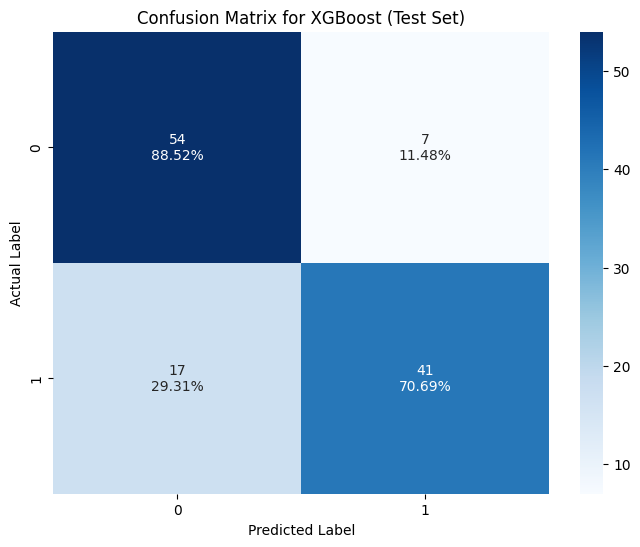

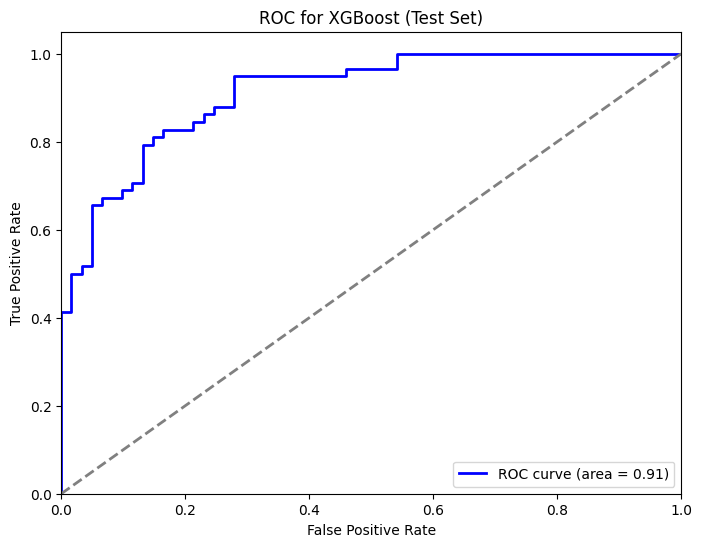


Test Set Metrics:
  Accuracy Precision Recall F1_Score    MCC ROC_AUC
0    0.798     0.854  0.707    0.774  0.603   0.912


In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Define parameter values directly
n_estimators_list = [100, 200, 300, 400, 500]
max_depth_list = [3, 4, 5, 6, 7]
learning_rate_list = [0.01, 0.02, 0.05, 0.1]

# Set up parameter grid for grid search
param_grid_xgb = {
    'n_estimators': n_estimators_list,
    'max_depth': max_depth_list,
    'learning_rate': learning_rate_list
}

# Instantiate XGBoost classifier and conduct grid search
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
grid_search_xgb = GridSearchCV(xgb_clf, param_grid_xgb, scoring='accuracy', cv=cv)
grid_search_xgb.fit(X_train, y_train)

# Output the optimal parameters
best_params_xgb = grid_search_xgb.best_params_
best_model_xgb = grid_search_xgb.best_estimator_
print("Optimal parameters:", best_params_xgb)

# Predict and Evaluate on Training Set
cv_metrics_xgb_train = evaluate_cross_validation(best_model_xgb, X_train, y_train)
print("\nTraining Set - 10-Fold Cross Validation Metrics:")
print(cv_metrics_xgb_train)

# Predict and Evaluate on Test Set
y_pred_test_xgb = best_model_xgb.predict(X_test)
y_pred_proba_test_xgb = best_model_xgb.predict_proba(X_test)[:, 1]
metrics_dict_xgb_test = evaluate_model(y_test, y_pred_test_xgb, y_pred_proba_test_xgb)

# Visualization and Saving Plots
plot_confusion_matrix(metrics_dict_xgb_test['Confusion Matrix'], title='Confusion Matrix for XGBoost (Test Set)', filename='confusion_matrix_XGB_test.png')
plot_roc_curve(y_test, y_pred_proba_test_xgb, title='ROC for XGBoost (Test Set)', filename='roc_curve_XGB_test.png')

# Convert Evaluation Metrics to DataFrame
metrics_df_xgb_test = pd.DataFrame({k: [v] for k, v in metrics_dict_xgb_test.items() if k != 'Confusion Matrix'})

# Display Metrics DataFrames
print("\nTest Set Metrics:")
print(metrics_df_xgb_test)


## **3.4 Comparison of Results of Machine Learning Models**

In [ ]:
import pandas as pd

# Convert model evaluation results to DataFrame with English labels
def metrics_to_df(metrics_dict, model_name):
    filtered_metrics = {k: v for k, v in metrics_dict.items() if k != 'Confusion Matrix'}
    return pd.DataFrame(filtered_metrics, index=[model_name])

# Convert and merge training set cross-validation results
combined_metrics_train = pd.concat([
    metrics_to_df(cv_metrics_svm_train, 'SVM'),
    metrics_to_df(cv_metrics_rf_train, 'RF'),
    metrics_to_df(cv_metrics_xgb_train, 'XGBoost'),
], axis=0)

# Merge test set evaluation results
combined_metrics_test = pd.concat([
    metrics_df_svm_test.rename(index={0: 'SVM'}),
    metrics_df_rf_test.rename(index={0: 'RF'}),
    metrics_df_xgb_test.rename(index={0: 'XGBoost'}),
], axis=0)

# Display merged tables
print("Combined Metrics - Training Set(10-fold CV):")
print(combined_metrics_train)
print("\nCombined Metrics - Test Set:")
print(combined_metrics_test)

Combined Metrics - Training Set(10-fold CV):
        Accuracy Precision Recall F1_score    MCC ROC_AUC
SVM        0.854     0.848  0.862    0.851  0.714   0.936
RF         0.801     0.847  0.729    0.780  0.610   0.896
XGBoost    0.801     0.829  0.750    0.785  0.607   0.874

Combined Metrics - Test Set:
        Accuracy Precision Recall F1_Score    MCC ROC_AUC
SVM        0.866     0.889  0.828    0.857  0.732   0.964
RF         0.765     0.875  0.603    0.714  0.552   0.913
XGBoost    0.798     0.854  0.707    0.774  0.603   0.912


# **4. Feature Importance Analysis**

---

**SHapley Additive exPlanations(SHAP)**

In [ ]:
pip install shap

   ---------------------------------------- 0.0/448.0 kB ? eta -:--:--
   ---------- ----------------------------- 112.6/448.0 kB 3.3 MB/s eta 0:00:01
   ------------------------ --------------- 276.5/448.0 kB 3.4 MB/s eta 0:00:01
   ------------------------------------ --- 409.6/448.0 kB 3.2 MB/s eta 0:00:01
   ---------------------------------------- 448.0/448.0 kB 2.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   -- ------------------------------------- 0.1/2.6 MB 4.2 MB/s eta 0:00:01
   --- ------------------------------------ 0.3/2.6 MB 3.1 MB/s eta 0:00:01
   ---- ----------------------------------- 0.3/2.6 MB 2.8 MB/s eta 0:00:01
   ----- ---------------------------------- 0.4/2.6 MB 2.1 MB/s eta 0:00:02
   ------ --------------------------------- 0.5/2.6 MB 2.2 MB/s eta 0:00:01
   ------ --------------------------------- 0.5/2.6 MB 2.2 MB/s eta 0:00:01
   ------- -------------------------------- 0.5/2.6 MB 1.6 MB/s eta 0:00:02
   -----

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


Using 472 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████████████████████████████████████████████████████████████████████████| 119/119 [1:49:24<00:00, 55.16s/it]


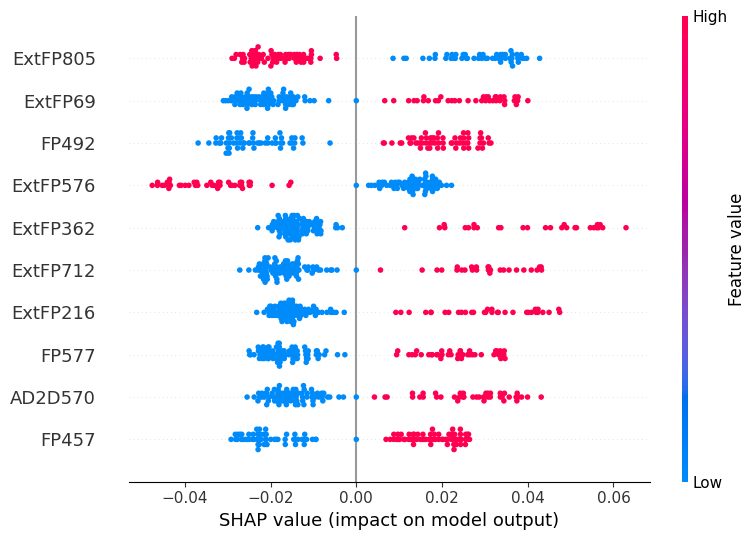

In [ ]:
import shap

# Load JavaScript visualization code into Jupyter notebook
shap.initjs()

# Create an explainer
explainer = shap.KernelExplainer(best_model_svm.predict_proba, X_train)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Visualize the top 10 most important features
shap.summary_plot(shap_values[1], X_test, max_display=10)